# Analysis of FIFA2020 Players

## Content

    
* [Introduction](#Introduction)
    * [Variable Description](#Variable_Description)
* [Objectives](#Objectives)
* [1. Web Scrapping](#Web_Scrapping)
* [2. Data Preparation](#Data_Preparation)
    * [Checking for missing values](#Checking_for_missing_values)
    * [Changing Position to Position Groups](#Changing_Position_to_Position_Groups)
    * [Creating League variable](#Creating_League_variable)
* [3. Data Analysis](#Data_Analysis)
    * [3.1 Analysis countries by players parametrs](#Analysis_countries)
    * [3.2 Analysis leagues by player parametrs](#Analysis_leagues)
    * [3.3 Analysis player rating-to-age ratio and rating-to-position, reputation-to-age](#Analysis_player)
    * [3.4 Right-handed vs left-handed](#Right-handed)
    * [3.5 Analysis of the 2019-2020 Champions League final winner's club](#Analysis_of_the)
* [4. Conclusion](#Conclusion)

<div style="background: #0f214f;">
    <img src="https://piunikaweb.com/wp-content/uploads/2020/03/image_1585670159337.jpg" width="82%">
</div>

<a id="Introduction"></a>
# Introduction
FIFA 20 is a football simulation video game published by Electronic Arts as part of the FIFA series. Each player in FIFA has an overall rating as well as six scores for the key stats; Pace, Shooting, Passing, Dribbling, Defending, and Physical. These stats are combined with a player's international recognition to calculate the player's overall rating.

<div style="background: #0f214f;">
    <img src="https://www.footboom.net/img/upload/2/59edc-FIFA-18.jpeg" width="70%">
</div>

<a id="Variable_Description"></a>
## Variable Description
1. full_name - name and surname of the player
2. age - age of the player
3. country - country of the player
4. club - his football club where he plays
5. rating - player rating(0-99) in the game
6. value - player value in euro
7. wage - player salary in euro
8. foot - leading leg
9. reputation - player's recognition internationally, player popularity, on a 5 point scale.
10. position - player's best position in the club
11. league - set of commands.

* int64(5): age, overall, value, wage, reputation
* object(6): full_name, country, club, foot, position, league

<a id="Objectives"></a>
# Objectives
1. <a style="text-decoration: none; color: black;" href="#Analysis_countries">Analysis countries by players parametrs</a>
2. <a style="text-decoration: none; color: black;" href="#Analysis_leagues">Analysis leagues by players parametrs</a>
3. <a style="text-decoration: none; color: black;" href="#Analysis_player">Analysis players ratings-to-age ratio and ratings-to-position, reputation-to-age</a>
4. <a style="text-decoration: none; color: black;" href="#Right_handed">Right-handed vs left-handed</a>
5. <a style="text-decoration: none; color: black;" href="#Analysis_of_the">Analysis of the 2019-2020 Champions League final winner's club</a>

### Libraries

In [1]:
import time
import csv
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup as BS
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px

<a id="Web_Scrapping"></a>
#  1. Web Scrapping

Below we are going to use BeautifulSoup for scraping from [`sofifa.com`](https://sofifa.com/).
The structure of the site is complex. Therefore, it is impossible to scrap it in a simple way, setting a limit on pages and reading through them.

We know that there are 60 players on each page. And we take all the data of these 60 players. Then we look for a button on the page to go to the next page, for the next 60 players. With this link we go to the next page. And so on until we reach the last page. And in the last page there is no button to go to the next page, and since we did not find the algorithm it stops.

In [182]:
#list where data will store
fifa20_df = []
#pages_url is a list where all next found links will be append(adding)
pages_url = ['https://sofifa.com/players?type=all&oah=99&showCol%5B%5D=ae&showCol%5B%5D=pf&showCol%5B%5D=oa&showCol%5B%5D=pt&showCol%5B%5D=vl&showCol%5B%5D=wg&showCol%5B%5D=ir&showCol%5B%5D=bp']

In [ ]:
START = time.time()   #we fix the started scraping time.

#we create a loop until the pages_url elements run out
for link in pages_url:
    
    req_link = requests.get(link)
    html = BS(req_link.content, 'lxml')

#We immediately look for the `next` button. If not, then stop the cycle.
#Since on each page there are two buttons `next` and `previous`, except for the first(only `next`) and last(only `previous`).
    if(2 == len(html.select('.pagination > a > span.bp3-button-text'))):
        #Checking for 2 means when there are two buttons `next` and `previous` on the page.
        if('Next' == html.select('.pagination > a > span.bp3-button-text')[1].text):
            pgntn = [a['href'] for a in html.select('.pagination > a[href]')]
            pgntn = pgntn[1]
            
            #If you find a button `next` then add it to the pages_url list.
            pgntn_link = 'https://sofifa.com' + str( pgntn )
            pages_url.append(pgntn_link)
    elif(1 == len(html.select('.pagination > a > span.bp3-button-text'))):
        #Checking for 1 means when there is one `next` or `previous` button on the page.
        if('Next' == html.select('.pagination > a > span.bp3-button-text')[0].text):
            pgntn = [a['href'] for a in html.select('.pagination > a[href]')]
            
            #If you find a button `next` then add it to the pages_url list.
            pgntn_link = 'https://sofifa.com' + str( pgntn[0] )
            pages_url.append(pgntn_link)
            
        else: 
            #If you did not find the next button and there is one button on the page then break loop
            print()
            break
#This is zero because at some points in the loop, the algorithm itself stops. 
#This is because the algorithm does not find the `next` button, although the selector is correct. 
#It is not clear why.
#I wrote a separate algorithm for this, which jumps to the next page in such cases.
    elif(0 == len(html.select('.pagination > a > span.bp3-button-text'))):
        #links only change the end, numbers and these numbers determine the number of offset players
        #Since it can be hundreds or thousands, we write an algorithm for different cases.
        #EXAMPLE: `https://sofifa.com/.../&offset=900`
        #   we change 900 to 901.
        #  and so on until we find the next button on the page again.
        # by the character `=` we determine the range of number in tail
        if(link[-4:-3] == '='):#for hundreds
            tail = link[-3:]
            tail = int(tail)
            tail += 5
            changed_link = link[:-3]
            changed_link = changed_link + str(tail)
            pages_url.append(changed_link)
            
            continue
        elif(link[-5:-4] == '='):#for thousands
            tail = link[-4:]
            tail = int(tail)
            tail += 5
            changed_link = link[:-4]
            changed_link = changed_link + str(tail)
            pages_url.append(changed_link)
            
            continue
        elif(link[-6:-5] == '='):#for 10 thousands
            tail = link[-5:]
            tail = int(tail)
            tail += 5
            changed_link = link[:-5]
            changed_link = changed_link + str(tail)
            pages_url.append(changed_link)
            
            continue
    
    i = 0
    players = 60 #number of players in one page
    #data extraction
    for element in html.select('tbody'):
        name = element.select('tr > td.col-name > a.tooltip > .bp3-text-overflow-ellipsis')
        age = element.select('tr > td.col-ae')
        country = element.select('tr > td.col-name > a.tooltip > .bp3-text-overflow-ellipsis > img')
        rating = element.select('tr > td.col-oa > span')
        club = element.select('tr > td.col-name > .bp3-text-overflow-ellipsis > a')
        foot = element.select('tr > td.col-pf')
        position = element.select('tr > td.col-bp > a > span.pos')
        value = element.select('tr > td.col-vl')
        wage = element.select('tr > td.col-wg')
        reputation = element.select('tr > td.col-ir')
        
        while i < players:
            #data extraction
            n = name[i].text
            ae = age[i].text
            cntr = country[i].get('title')
            rtg = rating[i].text
            clb = club[i].text
            ft = foot[i].text
            pstn = position[i].text
            vl = value[i].text
            wg = wage[i].text
            rpttn = reputation[i].text
            
            n = n[1:]
            if(vl[-1] == 'M'):
                vl = vl[1:-1]
                vl = str(int(float(vl)*1000000))
            elif(vl[-1] == 'K'):
                vl = vl[1:-1]
                vl = str(int(float(vl)*1000))
            elif(vl[-1] != 'K' and vl[-1] != 'M'):
                vl = vl[1:]
            if(wg[-1] == 'K'):
                wg = wg[1:-1]
                wg = str(int(float(wg)*1000))
            elif(wg[-1] != 'K'):
                wg = wg[1:]
            rpttn = rpttn[0:1]
            
            #Writing data to an array
            fifa20_df.append([n, ae, cntr, rtg, clb, ft, pstn, vl, wg, rpttn])
            i += 1
#Timing the end
END = time.time()
print('Time: ', round((END - START),2), 'sec')
print('Completed')

Due to the time it takes for web scraping(as you can see, more than 10 minutes) and the instability of the data on the site(deleting players, making changes to players, adding players), I will have to write them to a csv file and work with the data by the date 31.10.2020(the day I last did web scrapping) of the site sofifa.com.

#### Writing to the CSV file

In [8]:
column_name = ['full_name', 'age', 'country', 'rating', 'club', 'foot', 'position', 'value', 'wage', 'reputation']

with open('players.csv', "w", newline='', encoding="utf-8") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        
        writer.writerow(column_name)
        
        for line in data:
            writer.writerow(line)

<a id="Data_Preparation"></a>
#  2. Data Preparation

#### Reading from the CSV file

In [2]:
fifa20_df = pd.read_csv('players.csv')

In [3]:
fifa20_df = fifa20_df[['full_name', 'age', 'country', 'rating', 'club', 'foot', 'position', 'value', 'wage', 'reputation']]

In [4]:
fifa20_df.head()

full_name  age    country  rating                 club   foot  \
0           L. Messi   33  Argentina      93         FC Barcelona   Left   
1  Cristiano Ronaldo   35   Portugal      92             Juventus  Right   
2           J. Oblak   27   Slovenia      91      Atlético Madrid  Right   
3       K. De Bruyne   29    Belgium      91      Manchester City  Right   
4          Neymar Jr   28     Brazil      91  Paris Saint-Germain  Right   

  position      value    wage  reputation  
0       RW  103500000  560000           5  
1       ST   63000000  220000           5  
2       GK  120000000  125000           3  
3      CAM  129000000  370000           4  
4       LW  132000000  270000           5

<a id="Checking_for_missing_values"></a>
## Checking for missing values

In [5]:
fifa20_df = pd.read_csv('players.csv')

In [6]:
fifa20_df = fifa20_df[['full_name', 'age', 'country', 'rating', 'club', 'foot', 'position', 'value', 'wage', 'reputation']]

In [7]:
fifa20_df.shape

(18840, 10)

The dataset has 18840 players with 10 columns of data.

In [8]:
fifa20_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18840 entries, 0 to 18839
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   full_name   18840 non-null  object
 1   age         18840 non-null  int64 
 2   country     18840 non-null  object
 3   rating      18840 non-null  int64 
 4   club        18591 non-null  object
 5   foot        18840 non-null  object
 6   position    18840 non-null  object
 7   value       18840 non-null  int64 
 8   wage        18840 non-null  int64 
 9   reputation  18840 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.4+ MB


In [9]:
fifa20_df.isnull().sum()

full_name       0
age             0
country         0
rating          0
club          249
foot            0
position        0
value           0
wage            0
reputation      0
dtype: int64

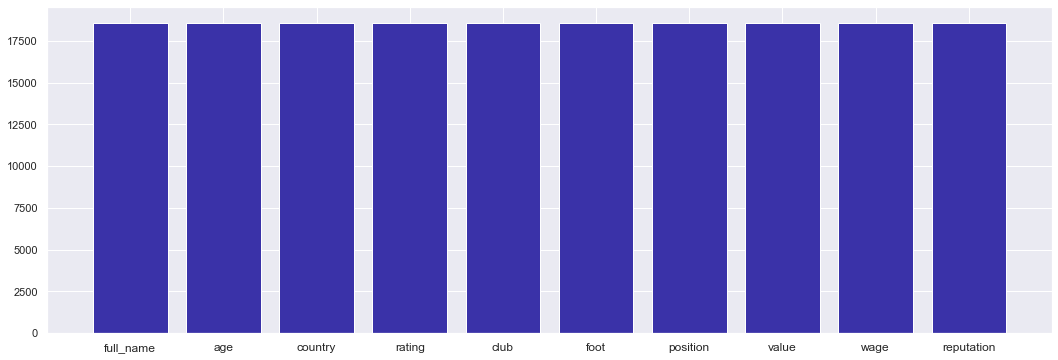

In [13]:
df_nulls = abs(fifa20_df.isnull().sum()-len(fifa20_df.index))

df_lessthan = [i if i != len(fifa20_df.index) else 0 for i in df_nulls]

fig = plt.subplots(figsize=(18,6))
plt.bar(df_nulls.index, df_nulls.values, color='#3a32a8')
plt.bar(df_nulls.index, df_lessthan, color='#a1b8cf')
plt.xticks(rotation = 0, fontsize = 12)
plt.show()

In this table, the columns with missing values are highlighted in gray. Looking at the table and previous informations, we can see that only the `club` column has 249 missing values. And as we can see here the number 249 does not play an important role in our dataset, so here I can drop rows with missing values.

In [14]:
fifa20_df = fifa20_df.dropna()
#After deleting rows with missing values, we adjust the indexes.
fifa20_df.reset_index(drop=True, inplace=True)
fifa20_df.tail()

full_name  age              country  rating  \
18586    H. Delgado   18              Ecuador      48   
18587     L. Walker   30              England      48   
18588     J. Browne   19  Republic of Ireland      48   
18589      M. Ćoćić   17               Serbia      48   
18590  Tan Chun Lok   24            Hong Kong      48   

                          club   foot position   value  wage  reputation  
18586  Independiente del Valle  Right       CB  120000   500           1  
18587       Milton Keynes Dons  Right       GK   30000  1000           1  
18588               Finn Harps  Right       ST  100000   500           1  
18589         TSV 1860 München   Left       LM  120000   500           1  
18590         Guangzhou R&F FC  Right       RM   70000  2000           1

<a id="Changing_Position_to_Position_Groups"></a>
## Changing Position to Position Groups.

In [15]:
position_groups = fifa20_df.groupby(['position']).sum()
len(position_groups)

15

As we can see here 15 type of positions. In order not to complicate our analysis, we will create 4 main groups of positions: forwards, мidfields, defenders, goalkeeper. 

In [16]:
position_groups

age  rating       value      wage  reputation
position                                                 
CAM       52515  147451  8418624997  21331000        2480
CB        92175  236559  8660439997  30737200        3915
CDM       36728   94454  4289269999  13698600        1555
CF         2328    5570   554784999   1954150         110
CM        26128   68549  4509029995  14065150        1177
GK        53273  131230  4332653997  13421750        2196
LB        26731   69141  2771869995   9301150        1103
LM        21571   57379  2668614997   7881600         924
LW         4852   12528   987594998   2878150         223
LWB        6046   16695   725449999   2168500         259
RB        26748   69819  2819679996   9611100        1120
RM        37482  101431  3758764996  11411200        1657
RW         7884   19853  1210314998   4458300         338
RWB        6710   18548   750819999   2270250         291
ST        66161  172513  7497964995  25168500        2924

As shown in the picture below. Forwards - red, мidfielders - yellow, defenders - blue, goalkeeper - grey.

Positions from the table will be distributed as follows: <br>
<span style="color:#fc0000">Forward</span> <= ( CF, RW, LW, ST )<br>
<span style="color:#e7e753">Midfielder</span> <= ( CAM, CDM, CM, LM, RM )<br>
<span style="color:#1e08fe">Defender</span> <= ( CB, LB, RB, LWB, RWB )<br>
<span style="color:#808080">Goalkeeper</span> <= ( GK )

<img src="https://sun9-7.userapi.com/hfcdaZx7LmnUrYwDaLZMyTv8j73InTjhDDHKYg/o-3U9IhTrPs.jpg" width="30%">

In [17]:
fifa20_df['position'].replace({'CF': 'Forward', 'CF': 'Forward', 'RW': 'Forward', 'LW': 'Forward', 'ST': 'Forward'}, inplace=True)
fifa20_df['position'].replace({'CAM': 'Midfielder','CM': 'Midfielder', 'CDM': 'Midfielder', 'RM': 'Midfielder', 'LM': 'Midfielder'}, inplace=True)
fifa20_df['position'].replace({'LWB': 'Defender', 'LB': 'Defender', 'CB': 'Defender', 'RB': 'Defender', 'RWB': 'Defender'}, inplace=True)
fifa20_df['position'].replace({'GK': 'Goalkeeper'}, inplace=True)

In [18]:
position_groups = fifa20_df.groupby(['position']).sum()
position_groups

age  rating        value      wage  reputation
position                                                     
Defender    158410  410762  15728259986  54088200        6688
Forward      81225  210464  10250659990  34459100        3595
Goalkeeper   53273  131230   4332653997  13421750        2196
Midfielder  174424  469264  23644304984  68387550        7793

<a id="Creating_League_variable"></a>
## Creating League variable

To achieve objective `2. Analysis leagues by player parametrs` we need to assign clubs to leagues.

A league is a collection of teams that play in the same championship. In football, each country has one or more football leagues. The first league is the strongest.

In [19]:
counter = fifa20_df.groupby(['club']).sum()
counter.shape

(681, 5)

This result shows that there are 681 clubs. But we will not distribute all clubs across all leagues. It will be convenient for us if we distribute them according to the most popular 9 leagues, and the rest of the clubs into one other group.

These 9 main leagues are:
1. German - Bundesliga
2. English - Premier League
3. Spanish - laliga
4. Italian - Serie A
5. French - Ligue1
6. Netherlands - Eredivisie
7. Portuguese - Liganos
8. Brazilian - Serie A
9. Turkish - Super League<br>
    +
10. Other Leagues

#### Find leagues with a list of clubs, web scraping.

We do not know and we do not have a list of 9 leagues clubs. To find the list of clubs in each league we need to do web scraping and take the list of clubs. We will search for a list of league clubs on `sofifa.com`

In [17]:
#links where there is a list of each `League` clubs
data_league = [['https://sofifa.com/teams?type=club&lg%5B%5D=19',18],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=13',20],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=53', 20],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=31',21],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=16',20],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=10',18],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=308',18],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=7',18],
               ['https://sofifa.com/teams?type=club&lg%5B%5D=68',20]]

In [18]:
clubs_league = [[],[],[],[],[],[],[],[],[],[]]

for i in range(0,9,1):
    page_url = data_league[i][0]
    
    req_to_page = requests.get(page_url)
    html = BS(req_to_page.content, 'lxml')
    
    #We extract everything we need
    name = html.select('tbody > tr > td.col-name-wide > a:nth-child(1) > div.bp3-text-overflow-ellipsis')

    j=0
    clubs = data_league[i][1]
    while j < clubs:

        n = name[j].text
        
        #We write them to the club_league array
        clubs_league[i].append(n)
        j+=1
    
print('Finish')

Finish


<i>Writing league clubs list to csv</i><br>
In order not to do web scraping every time, we save the list of league clubs in one file

In [19]:
league_list = ['bundesliga', 'premierLeague', 'laliga', 'italianseriea', 'league1', 'eredivisie', 'liganos', 'brazilseriea', 'superlig']
#We save each of the leagues as a separate file, this is convenient. We call the file the names of the leagues
for i in range(0,9,1):#a loop where we save data in different files
    
    link_to_file = 'clubs/' + league_list[i] + '.csv'
    
    with open(link_to_file, "w", newline='', encoding="utf-8")as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerows([x.split(',') for x in clubs_league[i]])

<i> Reading league clubs list</i>

In [20]:
league_list = ['bundesliga', 'premierLeague', 'laliga', 'italianseriea', 'league1', 'eredivisie', 'liganos', 'brazilseriea', 'superlig']
clubs_league = [[],[],[],[],[],[],[],[],[],[]]
#Reading league clubs into the club_league array
for i in range(0,9,1):#a loop where we extract data in different files
    
    link_to_file = 'clubs/' + league_list[i] + '.csv'
    
    with open(link_to_file, 'r', encoding="utf-8") as f:
        for eachLine in f:
            eachLine = eachLine[:-1]
            clubs_league[i].append([league_list[i], eachLine])

Creating new column for league

In [21]:
#In our main dataframe, add a league column and for now save the club name there.
fifa20_df['league']  = fifa20_df['club']
fifa20_df.head(1)

full_name  age    country  rating          club  foot position      value  \
0  L. Messi   33  Argentina      93  FC Barcelona  Left  Forward  103500000   

     wage  reputation        league  
0  560000           5  FC Barcelona

##### Grouping to leagues from getting clubs

When there is a list of league clubs, we can extract the data with a simple loop

In [22]:
#We are replacing the club name with the league name.
for j in clubs_league:
    for i in j:
        fifa20_df['league'].replace({i[1]: i[0]}, inplace=True)

In [23]:
#To sort the rest of the clubs outside these 9 leagues. we record the club indexes of these 9 leagues.
indexes = []
indexes.extend(fifa20_df[fifa20_df['league'] == 'bundesliga'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'premierLeague'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'laliga'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'italianseriea'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'league1'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'eredivisie'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'liganos'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'brazilseriea'].index)
indexes.extend(fifa20_df[fifa20_df['league'] == 'superlig'].index)

In [24]:
indexes.sort()#sorting for convenience

#we create another sheet from 0 to 18591. 
all_indexes = []
for i in range(0, 18591, 1):
    all_indexes.append(i)

#and find non-intersecting indices
diifference_indexes = []
diifference_indexes = list(set(all_indexes).difference(indexes))

#Replace the league names of other clubs to `other` using 'indexes' 
fifa20_df.at[diifference_indexes, 'league'] = 'other'

<a id="Creating_League_variable"></a>
## Creating ISO variable

To achieve objective `1. Analysis countries by player parametrs` we need to assign clubs to leagues.

In [25]:
#creating a new column for iso
fifa20_df['iso'] = fifa20_df['country']
fifa20_df.head(1)

full_name  age    country  rating          club  foot position      value  \
0  L. Messi   33  Argentina      93  FC Barcelona  Left  Forward  103500000   

     wage  reputation  league        iso  
0  560000           5  laliga  Argentina

From the wikipedia site using scrapping we take a list of countries and iso

In [26]:
listofcountries = []
page_url = 'https://en.wikipedia.org/wiki/List_of_FIFA_country_codes#FIFA_member_codes'

req_to_page = requests.get(page_url)
html = BS(req_to_page.content, 'lxml')

#extracting the necessary data from the site
name_of_countries = html.select('table.wikitable > tbody > tr > td > span > a')
code_of_countries = html.select('table.wikitable > tbody > tr > td:nth-child(2)')

i = 0
while i < 500:
    noc = name_of_countries[i].text
    coc = code_of_countries[i].text
    listofcountries.append([noc, coc[:-1]])
    i += 1
    if noc == 'Zimbabwe':#last(break) point where we stopped
        break

print('Complete')

Complete


In [27]:
len(listofcountries)

211

We have a list of 211 countries now we replace the countries in our dataset in the `iso` column

In [28]:
for j in listofcountries:
    fifa20_df['iso'].replace({j[0]: j[1]}, inplace=True)

Some countries don't have the correct iso so we change them manually

In [29]:
fifa20_df['iso'].replace({'ENG': 'GBR'}, inplace=True)
fifa20_df['iso'].replace({'GER': 'DEU'}, inplace=True)
fifa20_df['iso'].replace({'GER' : 'DEU'}, inplace=True)
fifa20_df['iso'].replace({'GUA': 'GTM'}, inplace=True)
fifa20_df['iso'].replace({'NCA': 'NIC'}, inplace=True)
fifa20_df['iso'].replace({'HON': 'HND'}, inplace=True)
fifa20_df['iso'].replace({'CRC': 'CRI'}, inplace=True)
fifa20_df['iso'].replace({'PAR': 'PRY'}, inplace=True)
fifa20_df['iso'].replace({'URU': 'URY'}, inplace=True)
fifa20_df['iso'].replace({'HAI': 'HTI'}, inplace=True)
fifa20_df['iso'].replace({'PUR': 'PRI'}, inplace=True)
fifa20_df['iso'].replace({'POR': 'PRT'}, inplace=True)
fifa20_df['iso'].replace({'NED': 'NLD'}, inplace=True)
fifa20_df['iso'].replace({'SUI': 'CHE'}, inplace=True)
fifa20_df['iso'].replace({'CRO': 'HRV'}, inplace=True)
fifa20_df['iso'].replace({'GRE': 'GRC'}, inplace=True)
fifa20_df['iso'].replace({'MTN': 'MRT'}, inplace=True)
fifa20_df['iso'].replace({'ALG': 'DZA'}, inplace=True)
fifa20_df['iso'].replace({'NIG': 'NER'}, inplace=True)
fifa20_df['iso'].replace({'CHA': 'TCD'}, inplace=True)
fifa20_df['iso'].replace({'CTA': 'CAF'}, inplace=True)
fifa20_df['iso'].replace({'CGO': 'COG'}, inplace=True)
fifa20_df['iso'].replace({'GUI': 'GIN'}, inplace=True)
fifa20_df['iso'].replace({'RSA': 'ZAF'}, inplace=True)
fifa20_df['iso'].replace({'ZAM': 'ZMB'}, inplace=True)
fifa20_df['iso'].replace({'ANG': 'AGO'}, inplace=True)
fifa20_df['iso'].replace({'ZIM': 'ZWE'}, inplace=True)
fifa20_df['iso'].replace({'TAN': 'TZA'}, inplace=True)
fifa20_df['iso'].replace({'MAD': 'MDG'}, inplace=True)
fifa20_df['iso'].replace({'KSA': 'SAU'}, inplace=True)
fifa20_df['iso'].replace({'MAS': 'MYS'}, inplace=True)
fifa20_df['iso'].replace({'PHI': 'PHL'}, inplace=True)
fifa20_df['iso'].replace({'CHI': 'CHL'}, inplace=True)
fifa20_df['iso'].replace({'DEN': 'DNK'}, inplace=True)

<a id="Data_Analysis"></a>
#  3. Data Analysis

3.1 [Analysis countries by players parametrs](#Analysis_countries)<br>
3.2 [Analysis leagues by player parametrs](#Analysis_leagues)<br>
3.3 [Analysis player rating-to-age ratio and rating-to-position, reputation-to-age](#Analysis_player)<br>
3.4 [Right-handed vs left-handed](#Right-handed)<br>
3.5 [Analysis of the 2019-2020 Champions League final winner's club](#Analysis_of_the)<br>

<a id="Analysis_countries"></a>
## 3.1 Analysis countries by players parametrs

In this part, we will analyze countries by parameters such as age wage and freequency of players by country. Does the number of players depend on age or salary?

In [30]:
#creating a new country_groups where we will store the average amount of data
country_groups = fifa20_df.groupby(['country', 'iso'], as_index=False).mean()
country_groups.head(1)

country  iso   age  rating      value    wage  reputation
0  Afghanistan  AFG  25.0    66.0  1150000.0  1500.0         1.0

In [31]:
#Total number for each group
count_numOfP = fifa20_df.groupby(['country'], as_index=False).count()
count_numOfP = count_numOfP.values.tolist()

In [32]:
#adding a new column where we will store the quantity
country_groups['quantity'] = country_groups['country']
#replace with the quantity.
for j in count_numOfP:
    country_groups['quantity'].replace({j[0]: j[1]}, inplace=True)
country_groups.head(1)

country  iso   age  rating      value    wage  reputation  quantity
0  Afghanistan  AFG  25.0    66.0  1150000.0  1500.0         1.0         2

In [33]:
count_numOfP = fifa20_df.groupby(['country'], as_index=False).count()
count_numOfP = count_numOfP.values.tolist()

In [34]:
#This is the text that comes out when you hover over a country
country_groups['text'] = 'country: ' + country_groups['country'] + ' <br>quantity: ' + country_groups['quantity'].astype(str)

In [35]:
country_groups.head(5)

country  iso        age     rating         value          wage  \
0  Afghanistan  AFG  25.000000  66.000000  1.150000e+06   1500.000000   
1      Albania  ALB  24.791667  64.708333  2.268125e+06   7095.833333   
2      Algeria  DZA  26.981132  70.679245  5.660377e+06  21943.396226   
3      Andorra  AND  30.000000  64.000000  4.750000e+05   1000.000000   
4       Angola  AGO  24.695652  67.652174  2.815435e+06   8413.043478   

   reputation  quantity                                  text  
0    1.000000         2  country: Afghanistan <br>quantity: 2  
1    1.041667        48     country: Albania <br>quantity: 48  
2    1.264151        53     country: Algeria <br>quantity: 53  
3    1.000000         1      country: Andorra <br>quantity: 1  
4    1.086957        23      country: Angola <br>quantity: 23

In [36]:
fig = px.choropleth(country_groups,
                    locations='iso',
                    color='quantity',
                    hover_name='text',
                    color_continuous_scale=px.colors.sequential.thermal
                   )
fig.update_layout(title = "Figure 1.1 The number of players for each country", 
                  width = 950,
                  margin = dict(l=0, r=0, b=100, t=80)
                  )
fig.show()

This chart shows that England are ahead in terms of the number of players. Since the League that is located in England, The English Premier League, is the most popular.

In [37]:
fig = px.choropleth(country_groups,
                    locations='iso',
                    color='age',
                    hover_name='text',
                    color_continuous_scale=px.colors.sequential.thermal
                   )
fig.update_layout(title = "Figure 1.2 Average age of players by country", 
                  width = 950,
                  margin = dict(l=0, r=0, b=100, t=80)
                  )
fig.show()

Here you can find out that the approximate age for many countries is 25 years. The youngest country by age is Malaysia. The oldest is Eritrea 32 years old. It depends on the number of players from each country for example from Malaysia only one player who is 18 years old is playing.

In [38]:
fig = px.choropleth(country_groups,
                    locations='iso',
                    color='wage',
                    hover_name='text',
                    color_continuous_scale=px.colors.sequential.thermal
                   )
fig.update_layout(title = 'Figure 1.3 Average wage of players by country', 
                  width = 950,
                  margin = dict(l=0, r=0, b=100, t=80)
                  )
fig.show()

On this map, you can find out that the highest-paid country by salary for each player is Tanzania. This again depends on the number of players from each country. Since there is only one player from Tanzania and the salary is 55 thousand, the average salary is high.

### Conclusion 'Analysis countries by players parametrs'
For this part we can say that England is the leading country in terms of quantity and the ratio of quantity and salary, since the salary is 9,540€, which is not a bad. And the average age is ~ 24 years. 

<a id="Analysis_leagues"></a>
## 3.2 Analysis leagues by player parametrs

In this part, we will analyze leagues by such parameters as age, reputation, rating, wage, value. What determines the popularity of the English Premier League?

In [39]:
#here we group and find out the total number of players from each League
leagues = fifa20_df.groupby(['league'], as_index=False).count()
leagues = leagues.sort_values(by=['full_name'])

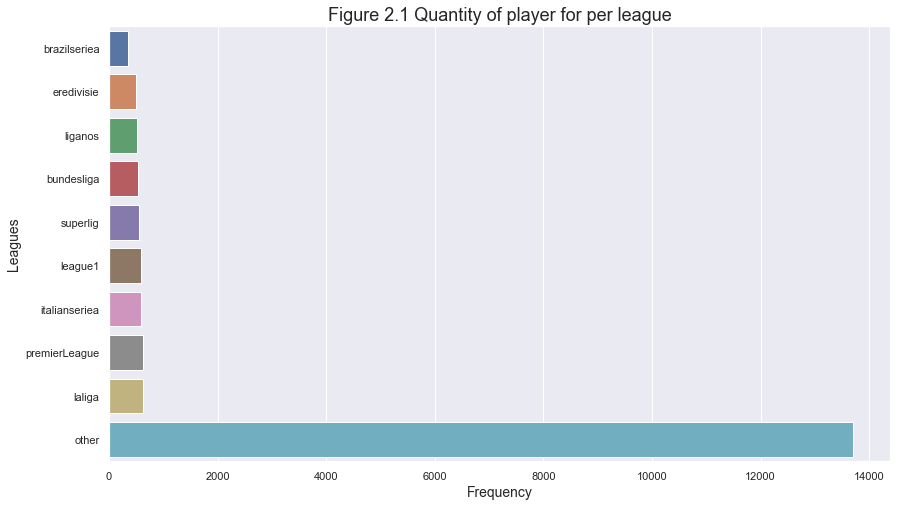

In [40]:
plt.figure(figsize = (14,8))

ax = sns.barplot(x='full_name', 
                y='league', 
                data=leagues, 
                palette='deep')
ax.set_title("Figure 2.1 Quantity of player for per league", size = 18)
ax.set_ylabel('Leagues', size = 14)
ax.set_xlabel('Frequency', size = 14)
ax.xaxis.grid(True)

According to this graph, you can find out that the number of players in each League does not exceed 500, except for others, because all the remaining teams are here

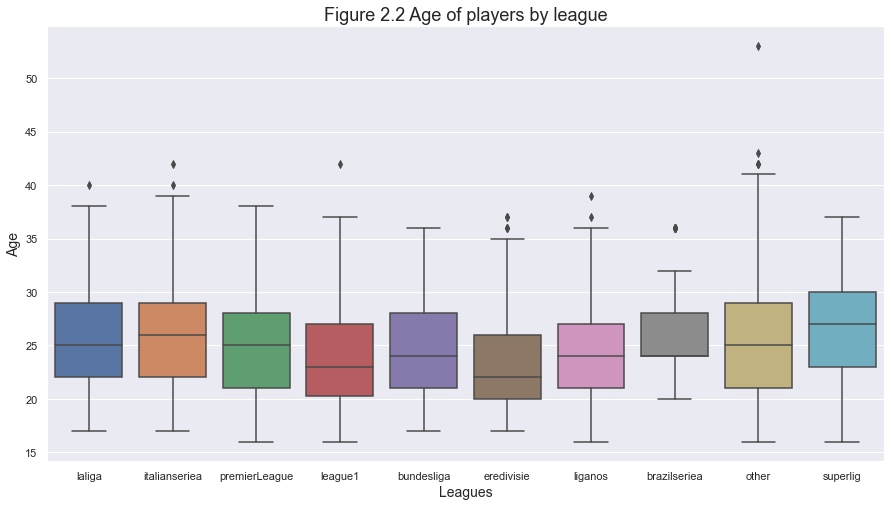

In [41]:
plt.figure(figsize = (15,8))
#plt.suptitle('Distribution of passenger Ages', size=16)

# plt.subplot(1,1,1)
ax = sns.boxplot(x='league',
                 y = 'age', 
                 data=fifa20_df, 
                 palette='deep',
                # showfliers=False
                )

#ax.set_title("Quantity of player for per league", size = 18)
plt.title("Figure 2.2 Age of players by league", size = 18)
#ax.set_ylabel("Age", size = 14)
plt.ylabel("Age", size=14)
#ax.set_xlabel("Leagues", size = 14)
plt.xlabel("Leagues", size=14)

ax.yaxis.grid(True)

This chart shows that other leagues is the oldest and there are three outliers and one is over 50 years old. Apart from this League the most terrible is The Italian Serie A.

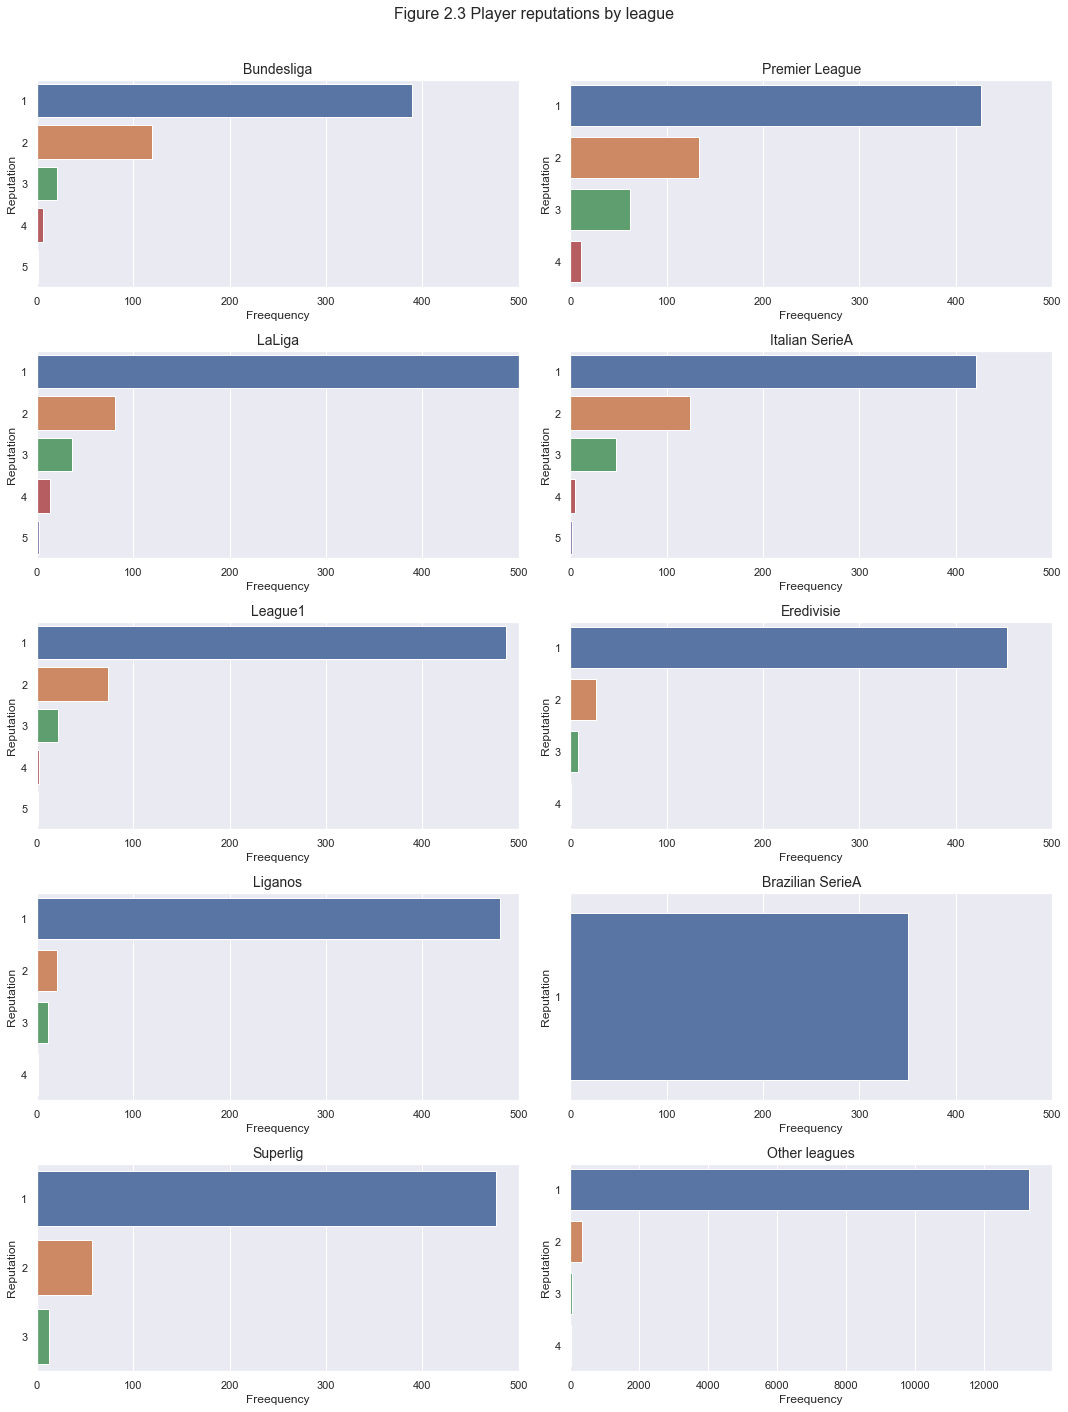

In [42]:
#Here we use subplot and loop to create a graph
plt.figure(figsize = (15,20))
plt.suptitle('Figure 2.3 Player reputations by league', size=16)

#Here we write the names of the leagues for output to title
leaguenames = ["Bundesliga","Premier League","LaLiga","Italian SerieA","League1","Eredivisie","Liganos","Brazilian SerieA","Superlig","Other leagues"]

n = 1 
while n != 11:
    
    if n == 1:
        dataset = fifa20_df[fifa20_df['league'] == 'bundesliga'].groupby(['reputation'], as_index=False).count()
    elif n == 2:
        dataset = fifa20_df[fifa20_df['league'] == 'premierLeague'].groupby(['reputation'], as_index=False).count()
    elif n == 3:
        dataset = fifa20_df[fifa20_df['league'] == 'laliga'].groupby(['reputation'], as_index=False).count()
    elif n == 4:
        dataset = fifa20_df[fifa20_df['league'] == 'italianseriea'].groupby(['reputation'], as_index=False).count()
    elif n == 5:
        dataset = fifa20_df[fifa20_df['league'] == 'league1'].groupby(['reputation'], as_index=False).count()
    elif n == 6:
        dataset = fifa20_df[fifa20_df['league'] == 'eredivisie'].groupby(['reputation'], as_index=False).count()
    elif n == 7:
        dataset = fifa20_df[fifa20_df['league'] == 'liganos'].groupby(['reputation'], as_index=False).count()
    elif n == 8:
        dataset = fifa20_df[fifa20_df['league'] == 'brazilseriea'].groupby(['reputation'], as_index=False).count()
    elif n == 9:
        dataset = fifa20_df[fifa20_df['league'] == 'superlig'].groupby(['reputation'], as_index=False).count()
    elif n == 10:
        dataset = fifa20_df[fifa20_df['league'] == 'other'].groupby(['reputation'], as_index=False).count()
    
    #Using the loop replacing `n` in subplot, we create nine graphs
    plt.subplot(5,2,n)
    sns.set()
    ax = sns.barplot(x='full_name', y='reputation', data=dataset, palette='deep',orient='h')
    ax.set_title(leaguenames[n-1], size = 14)
    ax.set_ylabel('Reputation', size = 12)
    ax.set_xlabel('Freequency', size = 12)
    ax.xaxis.grid(True)
    if n != 10:
        ax.set(xlim=(0,500))
        #Setting the default range, except other leagues, because it is higher than 500
    
    
    n+=1

plt.tight_layout(rect=[0, 0, 1, 0.95])

According to these charts, we can say that players with 5 reputations are only in the leagues: Bundesliga, La Liga, Italian Serie A and only one from Liga1 who is Neymar which came from La Liga. 
Despite the fact that the English Premier League is the most popular League there is no player with a popularity of 5. It depends on the competition in the League table and the competition in the team. The winner of the Premier League in each year is always different.<br>
Another analysis can be made by looking at the Brazilian leagues and other leagues. In other leagues, there are players with popularity 2, 3, 4. This is because some popular players at the end of their career go to other non-popular clubs in non-popular leagues for money. And they play for a couple more years. And from Brazil, popular players are trying to move to more popular leagues and finish their careers there.

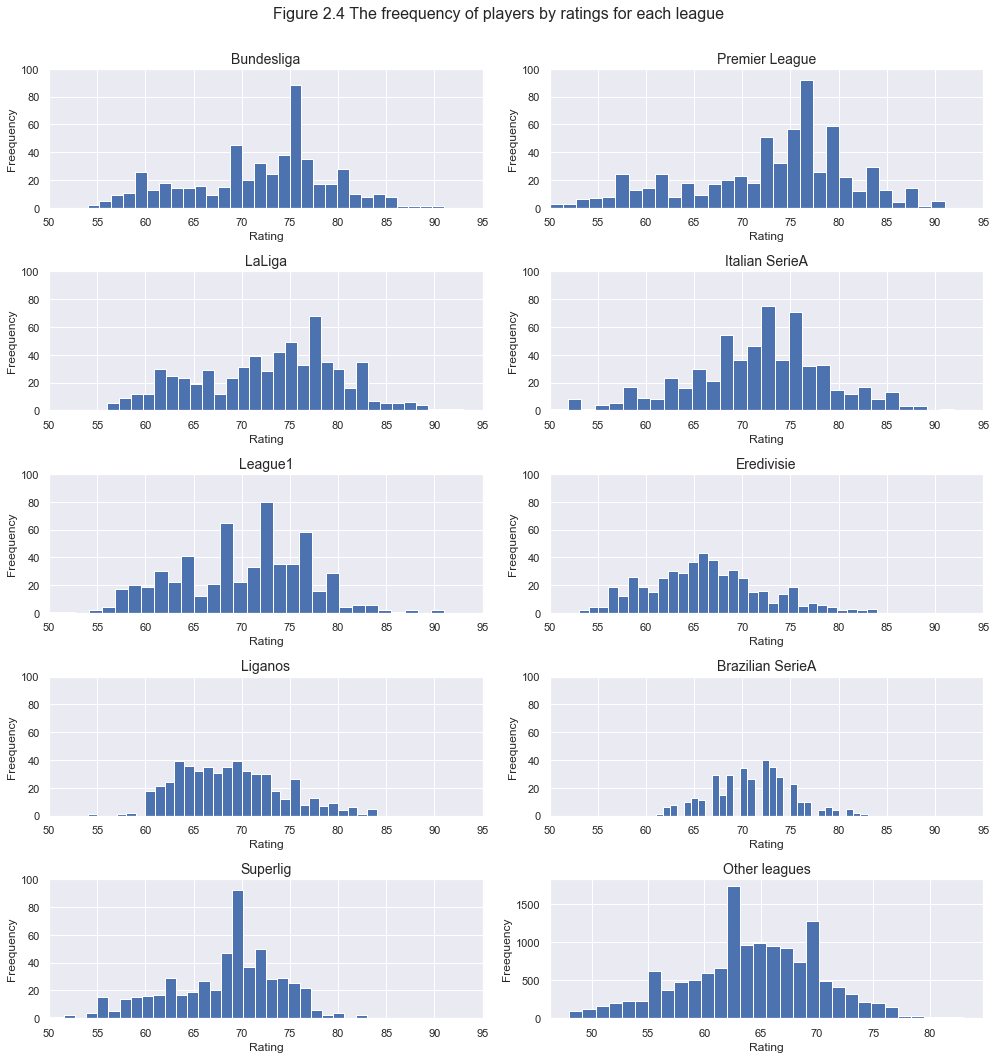

In [43]:
#Here we use subplot and loop to create a graph
plt.figure(figsize = (14, 15))
plt.suptitle('Figure 2.4 The freequency of players by ratings for each league', size = 16)

#Here we write the names of the leagues for output to title
listofleagues = ['bundesliga','premierLeague','laliga','italianseriea','league1','eredivisie','liganos','brazilseriea','superlig','other']
leaguenames = ["Bundesliga","Premier League","LaLiga","Italian SerieA","League1","Eredivisie","Liganos","Brazilian SerieA","Superlig","Other leagues"]

n = 1
while n != 11:
    plt.subplot(5,2,n)
    plt.hist(fifa20_df[fifa20_df['league'] == listofleagues[n-1]]['rating'], bins = 30)
    plt.xlabel("Rating", size = 12)
    plt.ylabel("Freequency", size = 12)
    plt.title(leaguenames[n-1], size = 14)
    if n != 10:
        plt.axis([50, 95, 0, 100])
        #Setting the default range, except other leagues
    n+=1

plt.tight_layout(rect=[0, 0, 1, 0.95])

According to these charts, you can say that players with better ratings are in the Premier League, given the number-rating. And there are more players with a level of 90 or higher than in other leagues. Looking at other leagues, we can say that the overall rating for all players is not higher than 65.
<a id='2.5'></a>

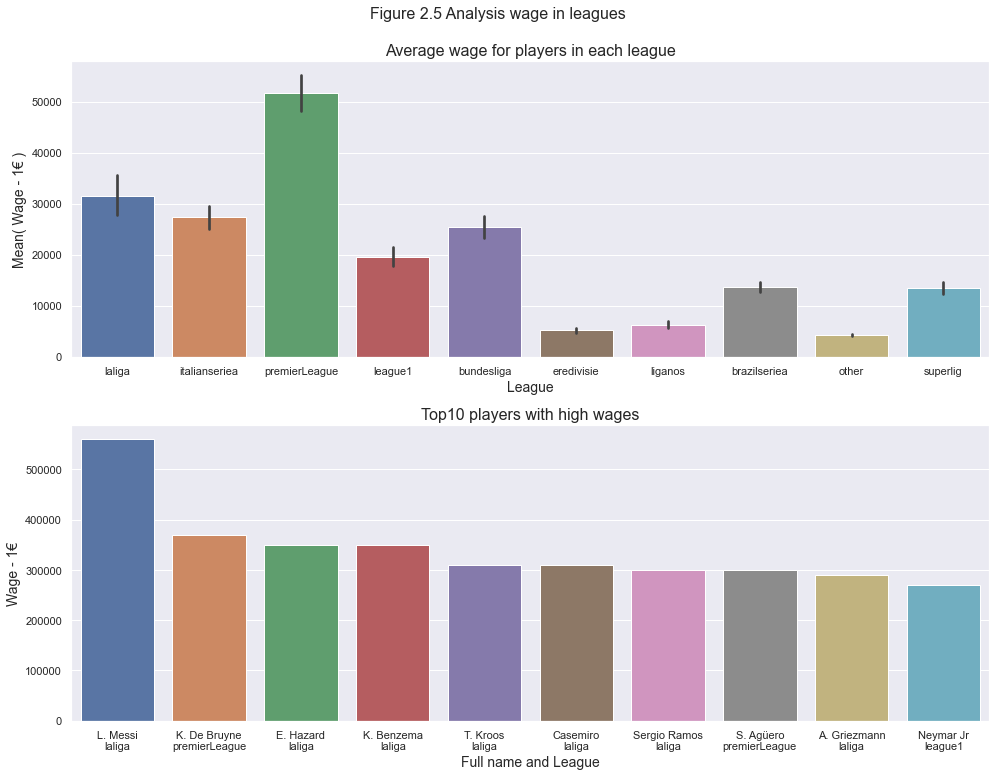

In [44]:
plt.figure(figsize = (14,11))
plt.suptitle('Figure 2.5 Analysis wage in leagues', size = 16)

#Creating a barplot for 9 leagues
plt.subplot(2,1,1)
ax = sns.barplot(x='league', 
                 y='wage', 
                 data=fifa20_df, 
                 palette='deep')
ax.set_title("Average wage for players in each league", size = 16)
ax.set_ylabel('Mean( Wage - 1€ )', size = 14)
ax.set_xlabel('League', size = 14)
ax.yaxis.grid(True)

#Top10 players with high wages
top10 = fifa20_df.sort_values('wage', ascending=False)[0:10]
top10['fnal'] = top10['full_name'] + '\n' + top10['league']

plt.subplot(2,1,2)
ax2 = sns.barplot(x='fnal', y='wage', data=top10);
ax2.set_title("Top10 players with high wages", size = 16)
ax2.set_ylabel('Wage - 1€', size = 14)
ax2.set_xlabel('Full name and League', size = 14)
ax2.yaxis.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])

The highest paid League is the Premier League. But from La Liga, 7 players are in the Top10 players with high wages in the world. Of these, Messi is the highest-paid player in the world. Which is much more than the average salary of its League.
<a id='2.6'></a>

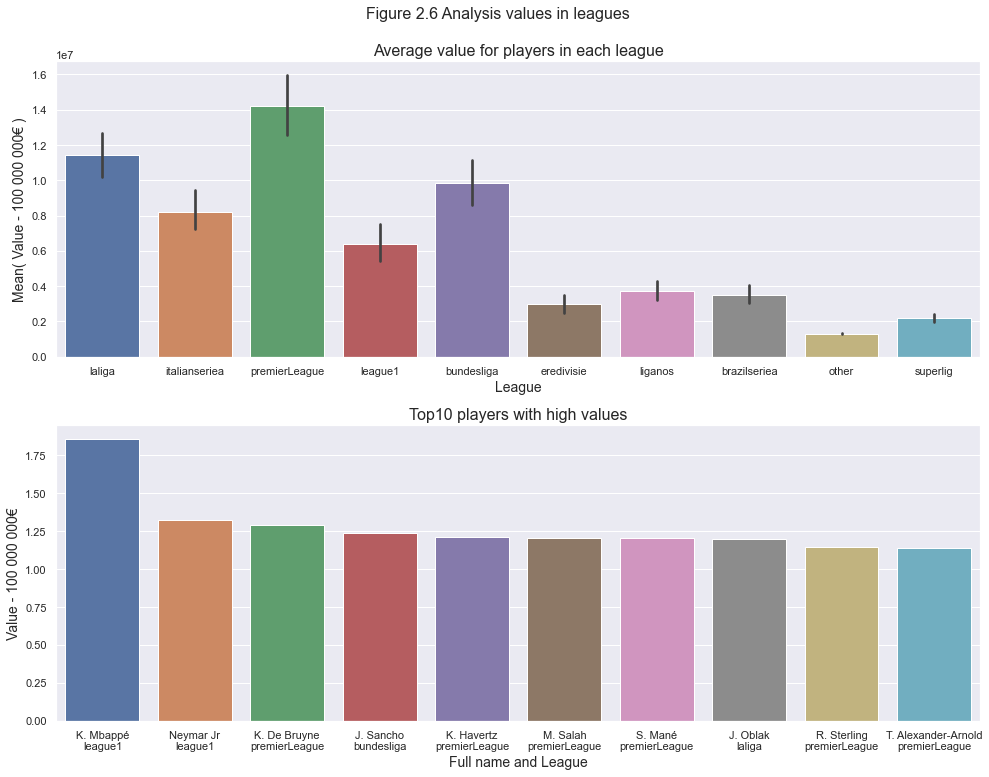

In [45]:
plt.figure(figsize = (14,11))
plt.suptitle('Figure 2.6 Analysis values in leagues', size = 16)

#the average values in leagues. 
plt.subplot(2,1,1)
ax = sns.barplot(x='league', 
                 y='value', 
                 data=fifa20_df, 
                 palette='deep')
ax.set_title("Average value for players in each league", size = 16)
ax.set_ylabel('Mean( Value - 100 000 000€ )', size = 14)
ax.set_xlabel('League', size = 14)
ax.yaxis.grid(True)

#Top10 players with high values
top10 = fifa20_df.sort_values('value', ascending=False)[0:10]
top10['fnal'] = top10['full_name'] + '\n' + top10['league']
top10['value'] = top10['value']/100000000

plt.subplot(2,1,2)
ax2 = sns.barplot(x='fnal', y='value', data=top10);
ax2.set_title("Top10 players with high values", size = 16)
ax2.set_ylabel('Value - 100 000 000€', size = 14)
ax2.set_xlabel('Full name and League', size = 14)
ax2.yaxis.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])

The most expensive League is the Premier League. From this League, 6 players are included in the Top10 players with high values. But the most expensive player is Mbappe from Ligue1.

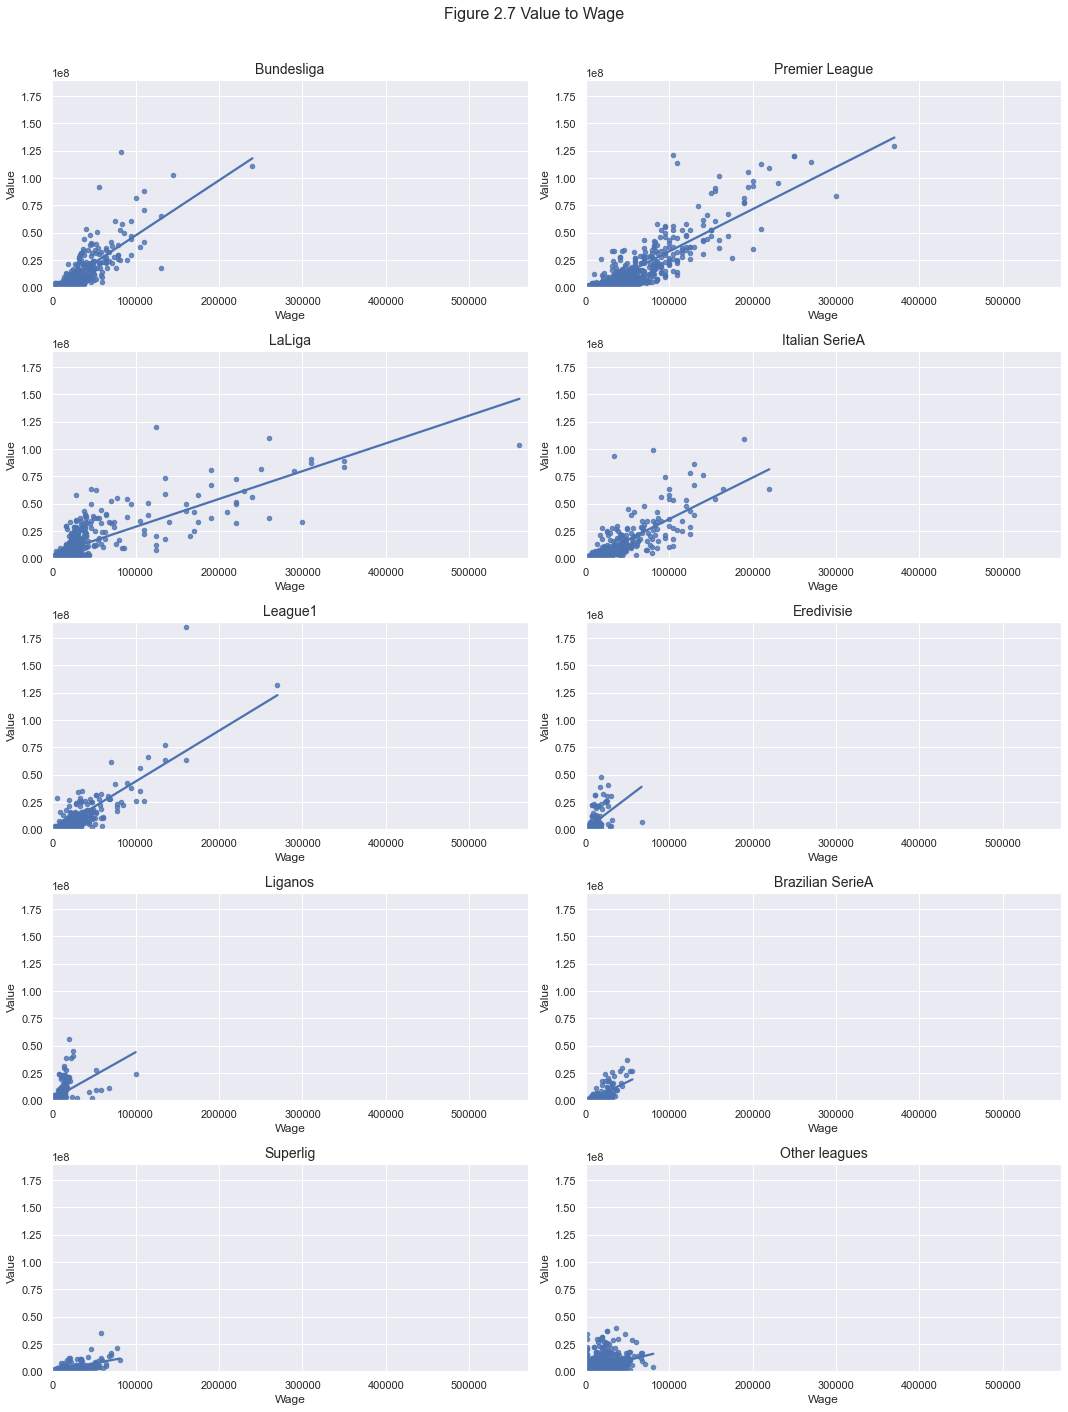

In [46]:
#Here we use subplot and loop to create a graph
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Figure 2.7 Value to Wage', size=16)

#Here we write the names of the leagues for output to title
listofleagues = ['bundesliga','premierLeague','laliga','italianseriea','league1','eredivisie','liganos','brazilseriea','superlig','other']
leaguenames = ["Bundesliga","Premier League","LaLiga","Italian SerieA","League1","Eredivisie","Liganos","Brazilian SerieA","Superlig","Other leagues"]

n = 1
col = 0 #the index for the columns
row = 0 #the index for the row
#changing the column and row, we go through all the charts and output.
while n != 11:
    sns.regplot(x='wage', 
               y='value', 
               data=fifa20_df[fifa20_df['league'] == listofleagues[n-1]],
               ci = None,
               marker='o',
               scatter_kws={'s': 20},
               ax=axes[col, row],
               #fit_reg=False
                );
    axes[col, row].set_title(leaguenames[n-1], size = 14)
    axes[col, row].set_ylabel('Value', size = 12)
    axes[col, row].set_xlabel('Wage', size = 12)
    axes[col, row].set(xlim=(0,570000),ylim=(0,190000000))
    #Setting the size for easy comparison of data.
    
    n+=1
    
    #Checking and changing columns and rows
    if row == 0:
        row+=1
    elif row == 1:
        row-=1
        col+=1


plt.tight_layout(rect=[0, 0, 1, 0.95])

This regplot clearly shows that La Liga is league with higher wage and the Premier League is leagues with higher values.But in two aspects, the best is still the Premier League.<br>
    As you can see from this and previous figure [2.5](#2.5) and [2.6](#2.6), we can say that the highest paid player is Messi 560,000€ and his value is 103 500 000€. Mbappe's most expensive player is 185 500 000€ and his weight is 160 000€. They are immediately visible on the chart and are obvious outliers.


### Conclusion 'Analysis leagues by player parametrs'
The English Premier League proved to be a priority. First, the player ratings of a large degree was more than 70. And the average wage and cost of players is higher than the rest. The age of 50% of the players was between about 21 and 27. And there are no outliers players. This proves that there is a lot of competition in the League between players.

<a id="Analysis_player"></a>
## 3.3 Analysis player rating-to-age ratio and rating-to-position, reputation-to-age

In this part, we will analyze the relationship of these parameters: rating-to-age, rating-to-position, reputation-to-age

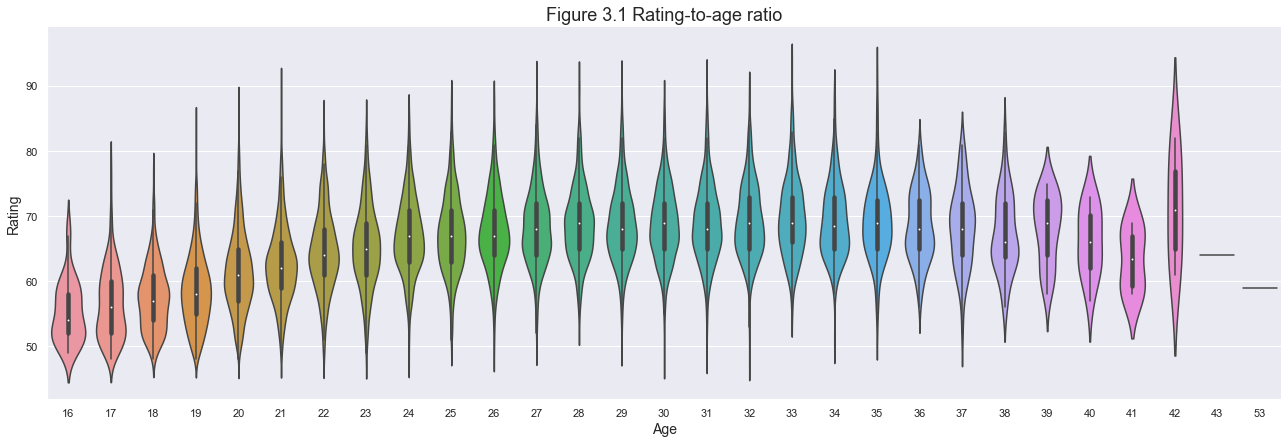

In [50]:
ax = sns.catplot(x='age',
                 y = 'rating', 
                 data=fifa20_df,
                 kind="violin", 
                 height=6, 
                 aspect=3
                )
ax = plt.title("Figure 3.1 Rating-to-age ratio", size = 18)
ax = plt.ylabel("Rating", size=14)
ax = plt.xlabel("Age", size=14)

In this section, you can see that the age range is from 16 to 53 years. And you can see that with increasing age, the rating also increases, which means that the more people play, the more experience increases and the rating increases, but this does not mean that everyone has players who lose their talent over the years and the rating decreases.

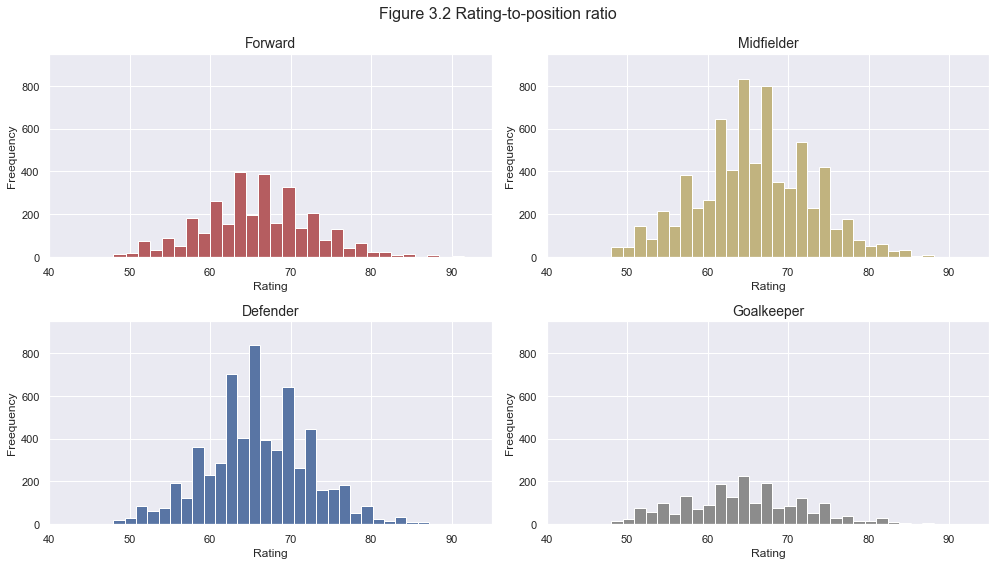

In [51]:
plt.figure(figsize = (14, 8))
plt.suptitle('Figure 3.2 Rating-to-position ratio', size = 16)

pos = ["Forward", "Midfielder", "Defender", "Goalkeeper"]
color = ['#b55d60', '#c1b37f', '#5975a4', '#8c8c8c']

n = 1
while n != 5:
    plt.subplot(2,2,n)
    plt.hist(fifa20_df[fifa20_df['position'] == pos[n-1]]['rating'], bins = 30, color = color[n-1])
    plt.xlabel("Rating", size = 12)
    plt.ylabel("Freequency", size = 12)
    plt.title(pos[n-1], size = 14)
    plt.axis([40, 95, 0, 950])
    n += 1

plt.tight_layout(rect=[0, 0, 1, 0.95])

In this table, you can see that for all positions, the average rating is between 60 and 70. And you can see that there are very few players rated 90 for midfield and defender.

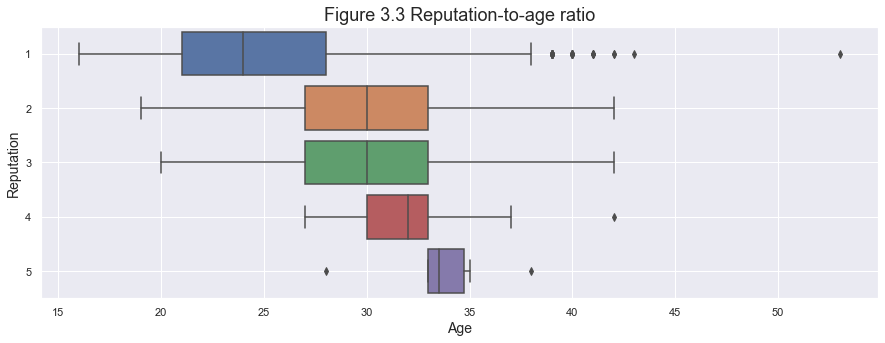

In [52]:
plt.figure(figsize = (15,5))

ax = sns.boxplot(x='age',
                 y = 'reputation', 
                 data=fifa20_df, 
                 palette='deep',
                 orient='h'
                )

plt.title("Figure 3.3 Reputation-to-age ratio", size = 18)
plt.ylabel("Reputation", size=14)
plt.xlabel("Age", size=14)

ax.yaxis.grid(True)

According to this chart, you can also see that players aged between about 25 and 35 have a five-star reputation, which also means that the greater the age, the greater the reputation. But we must not forget that the reputation is given despite the maintained constant rating and the League where the player plays, if it is not a popular League, then the player's popularity is also low. Therefore, we can say that the players who have a popularity of 5. They play in more popular leagues and have maintained their good ratings more consistently.

### Conclusion 'Analysis player rating-to-age ratio and rating-to-position, reputation-to-age'
The rating of a player depends to some extent on age the greater the age the greater the rating, but there are influencing such parametr as League. And the level does not depend on the player's position. A player's reputation is influenced by factors such as age, rating stability, and League.

<a id="Right-handed"></a>
## 3.4 Right-handed vs left-handed

In this part, we will find out which players(left-handed or right-handed) are successful and by what parameters?

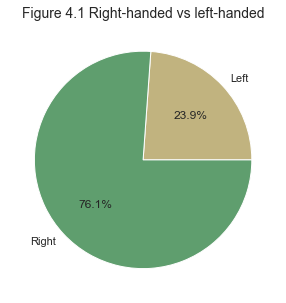

In [53]:
#grouping dataframe into two groups: left handed and right handed
foot = fifa20_df.groupby(['foot'], as_index = False).count()

#color for parts
clrs = ['#c1b37f','#5f9e6e']

plt.figure(figsize = (14, 5))
#Displaying the pie chart.
plt.pie(foot['full_name'], 
        labels = foot['foot'], 
        colors = clrs, 
        autopct='%1.1f%%',#displaying the percent
        shadow=False, 
        startangle=0)

plt.title('Figure 4.1 Right-handed vs left-handed', size = 14)
plt.show()

More than half of the players are right-handed. 

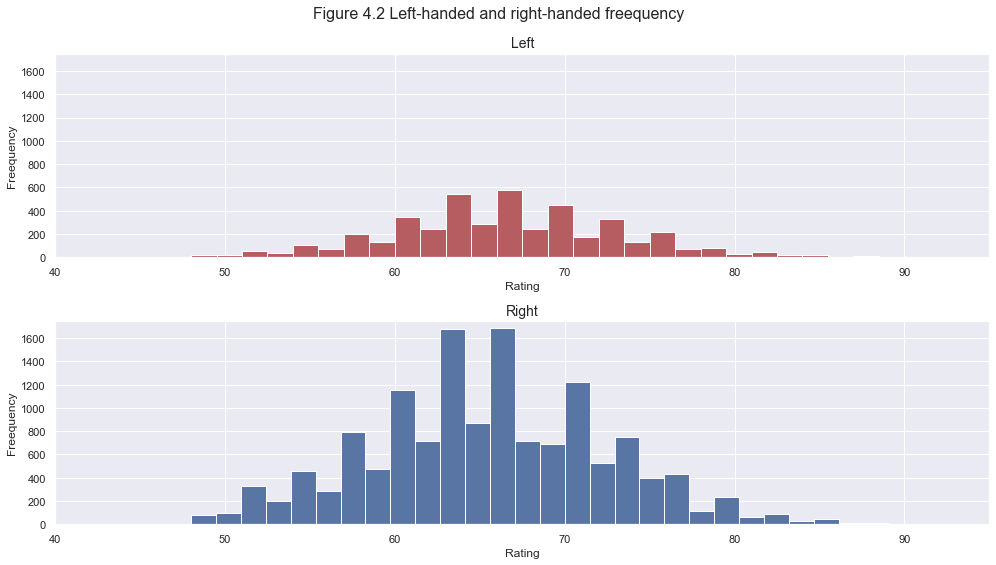

In [54]:
plt.figure(figsize = (14, 8))
plt.suptitle('Figure 4.2 Left-handed and right-handed freequency', size = 16)

#left-handed hist
plt.subplot(2,1,1)
plt.hist(fifa20_df[fifa20_df['foot'] == 'Left']['rating'], bins = 30, color = '#b55d60')
plt.xlabel("Rating", size = 12)
plt.ylabel("Freequency", size = 12)
plt.title('Left', size = 14)
plt.axis([40, 95, 0, 1750])

#right-handed hist
plt.subplot(2,1,2)
plt.hist(fifa20_df[fifa20_df['foot'] == 'Right']['rating'], bins = 30, color = '#5975a4')
plt.xlabel("Rating", size = 12)
plt.ylabel("Freequency", size = 12)
plt.title('Right', size = 14)
plt.axis([40, 95, 0, 1750])


plt.tight_layout(rect=[0, 0, 1, 0.95])

Here the data is almost similar for all ratings. The pattern is the same.

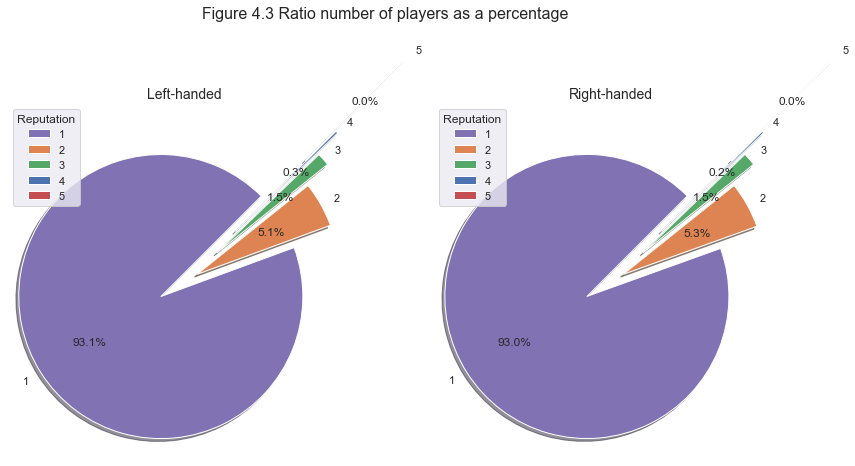

In [55]:
#We group by foot and reputation
gd = fifa20_df.groupby(['reputation', 'foot'], as_index = False).count()
clr = ['#8172b3','#dd8452','#55a868','#4c72b0','#c44e52']

plt.figure(figsize = (14, 8))
plt.suptitle('Figure 4.3 Ratio number of players as a percentage', size = 16)

#pie for left-handed
plt.subplot(1,2,1)
plt.pie(gd[gd['foot']=='Left']['full_name'], 
        labels = gd[gd['foot']=='Left']['reputation'],  
        autopct='%1.1f%%',
        shadow=True, #We need a shadow for all players with a reputation of 5
        startangle=45,
        colors = clr,
        explode = [0.2,0.1,0.3,0.5,1.2]
       )
plt.legend(title="Reputation")
plt.title('Left-handed', size = 14)

#pie for right-handed
plt.subplot(1,2,2)
plt.pie(gd[gd['foot']=='Right']['full_name'], 
        labels = gd[gd['foot']=='Right']['reputation'],  
        autopct='%1.1f%%',
        shadow=True, 
        startangle=45,
        colors = clr,
        explode = [0.2,0.1,0.3,0.5,1.2]#extract in order for easy viewing
       )

plt.legend(title="Reputation")
plt.title('Right-handed', size = 14)
plt.show()

By this pie, you can find out that the player ratios are the same.

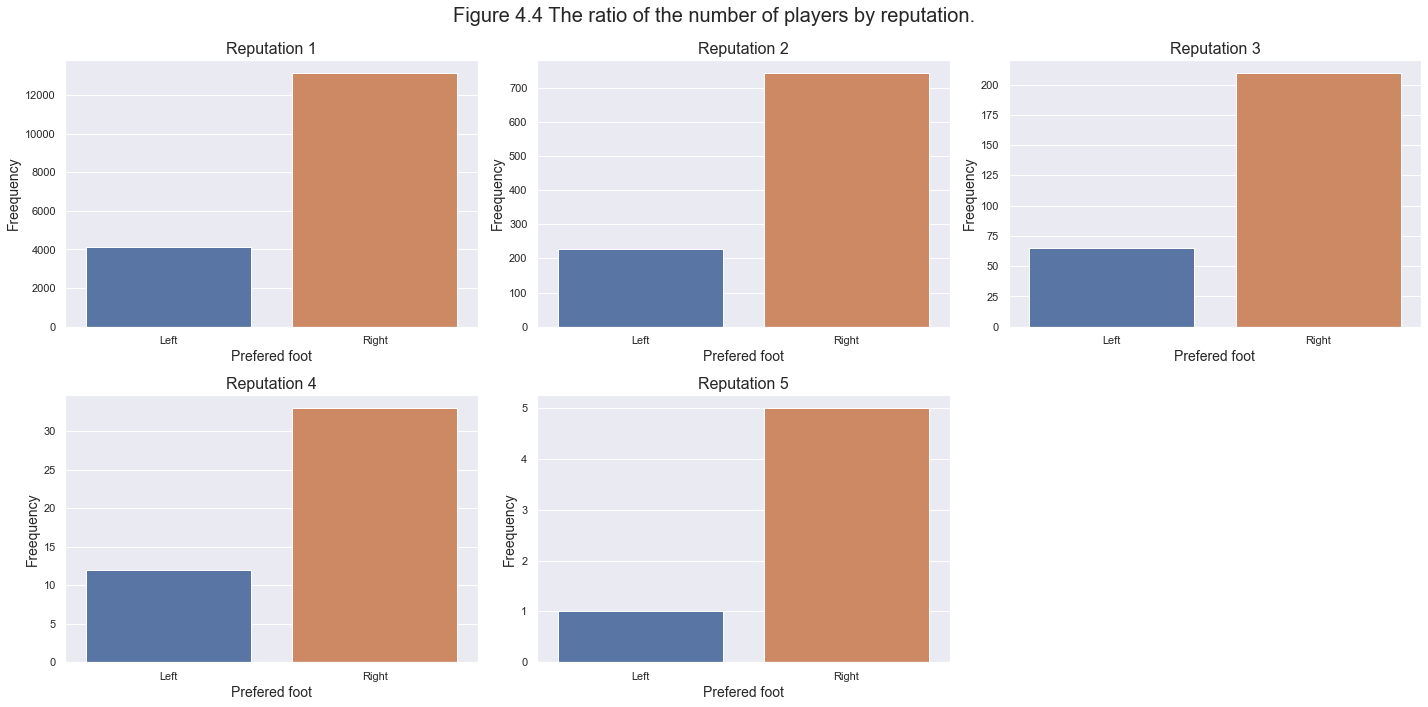

In [56]:
plt.figure(figsize = (20,10))
plt.suptitle('Figure 4.4 The ratio of the number of players by reputation.', size = 20)

#Prescribe a sheet to display for the title
rep_list = ['Reputation 1', 'Reputation 2', 'Reputation 3', 'Reputation 4', 'Reputation 5']

i = 1
while i != 6:    #Through the loop, changing the order number, we create 5 barplots by reputation
    plt.subplot(2,3,i)
    ax1 = sns.barplot(x=gd[gd['reputation']==i]['foot'], y=gd['full_name'])
    ax1.set_title(rep_list[i-1], size = 16)
    ax1.set_ylabel('Freequency', size = 14)
    ax1.set_xlabel('Prefered foot', size = 14)
    ax1.yaxis.grid(True)
    i+=1

plt.tight_layout(rect=[0, 0, 1, 0.95])

According to this graph, you can find out that the reputation of players does not depend on the fact that the player is right-handed or left-handed. The ratio here is also proportional

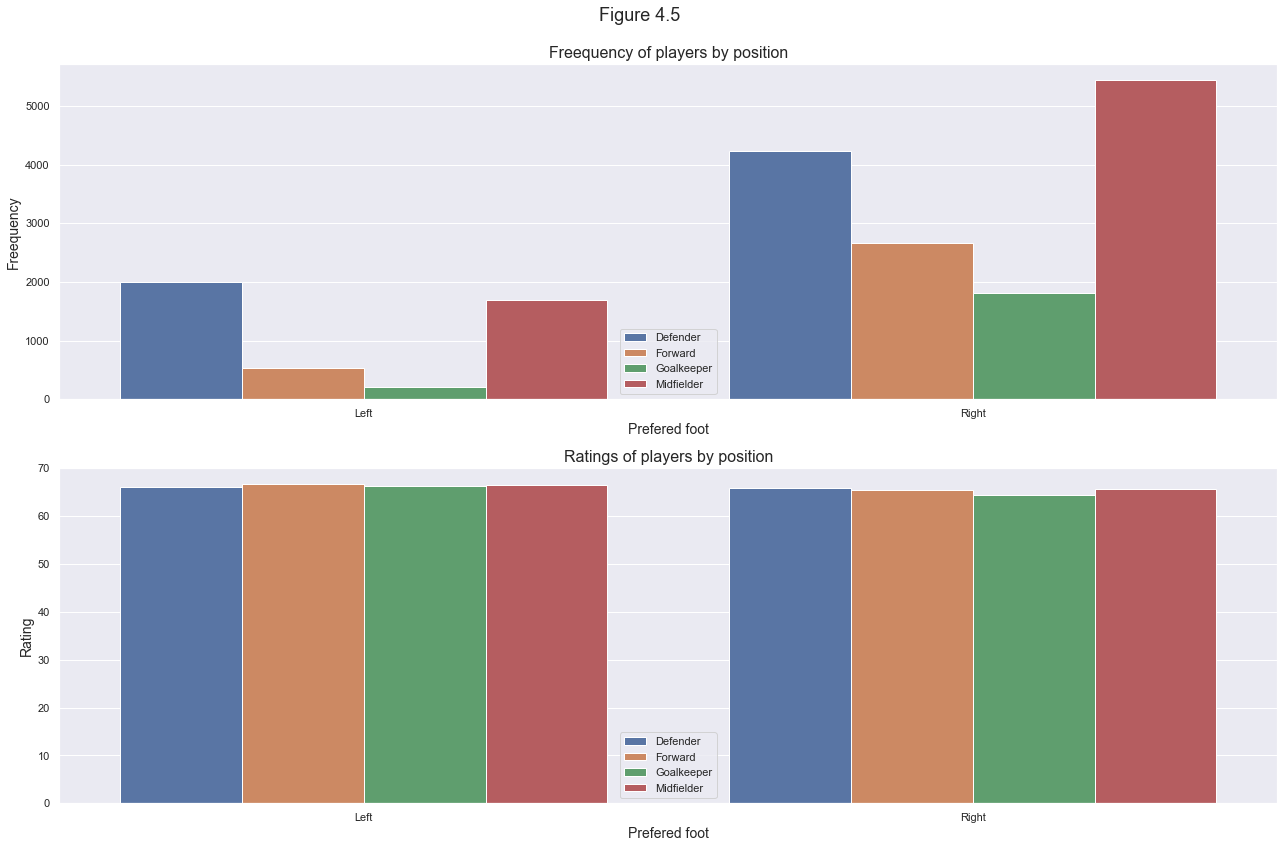

In [57]:
gpc = fifa20_df.groupby(['position', 'foot'], as_index = False).count()
gpm = fifa20_df.groupby(['position', 'foot'], as_index = False).mean()
plt.figure(figsize = (18,12))
plt.suptitle('Figure 4.5 ', size = 18)

plt.subplot(2,1,1)
ax1 = sns.barplot(x=gpc['foot'], y=gpc['rating'], hue=gpc['position'])
ax1.legend(loc = 'lower center')
ax1.set_title("Freequency of players by position", size = 16)
ax1.set_ylabel('Freequency', size = 14)
ax1.set_xlabel('Prefered foot', size = 14)
ax1.yaxis.grid(True)

plt.subplot(2,1,2)
ax2 = sns.barplot(x=gpm['foot'], y=gpm['rating'], hue=gpm['position'])
ax2.legend(loc = 'lower center')
ax2.set_title("Ratings of players by position", size = 16)
ax2.set_ylabel('Rating', size = 14)
ax2.set_xlabel('Prefered foot', size = 14)
ax2.yaxis.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])

Although the number of players is different in positions, they maintain the same ratings. But you can see that although the number of midfields is greater their average rating has not fallen but exceeds the turnover.

### Conclusion 'Right-handed vs left-handed' 
The success of player does not depend on the leg, this analysis proved that for both the results are prorotional.

<a id="Analysis_of_the"></a>
## 3.5 Analysis of the 2019-2020 Champions League final winner's club

The winner of the 2019-2020 Champions League final was FC Bayern Munich and its opponent was Paris Saint-Germain. We will compare the team parameters and try to find the secret of victory.

In [58]:
#for convenience, we create separate data frames for each of the two clubs
bayern = fifa20_df[fifa20_df['club']=='FC Bayern München']
bayern.reset_index(drop=True, inplace=True)

psg = fifa20_df[fifa20_df['club']=='Paris Saint-Germain']
psg.reset_index(drop=True, inplace=True)

In [59]:
#concatenate them into one to display the barplot graph
bp_df = pd.concat([bayern, psg])
#import plotly.express as px
bp = bp_df.groupby(['club', 'position'], as_index = False).mean()

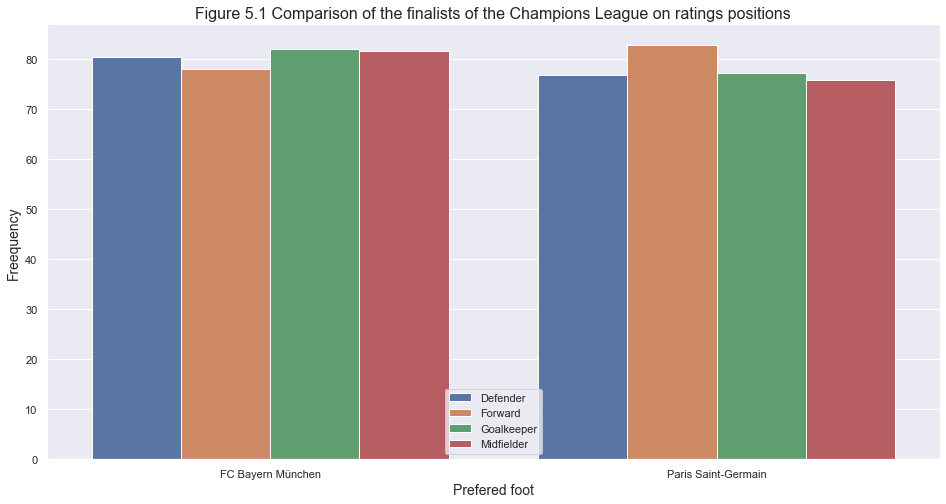

In [60]:
plt.figure(figsize = (16,8))

ax = sns.barplot(x=bp['club'], y=bp['rating'], hue=bp['position'])
ax.set_title("Figure 5.1 Comparison of the finalists of the Champions League on ratings positions", size = 16)
ax.set_ylabel('Freequency', size = 14)
ax.set_xlabel('Prefered foot', size = 14)
ax.legend(loc = 'lower center')
ax.yaxis.grid(True)

Here you can find out that the Parisians have a great attack, but they are lagging behind in the other three positions.

In [61]:
bapr = bayern.groupby(['position'], as_index = False).mean()
papr = psg.groupby(['position'], as_index = False).mean().sort_values(by = 'position', ascending=True)

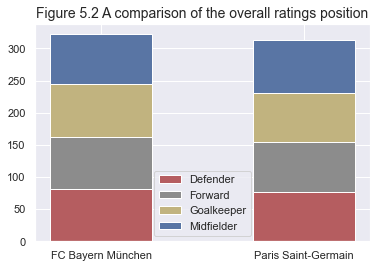

In [62]:
# Data
r = ['FC Bayern München','Paris Saint-Germain']
fdf = []
mdf = []
ddf = []
gdf = []
fdf = bapr[bapr['position']=='Forward']
fdf = fdf.append(papr[papr['position']=='Forward'])
mdf = bapr[bapr['position']=='Midfielder']
mdf = mdf.append(papr[papr['position']=='Midfielder'])
ddf = bapr[bapr['position']=='Defender']
ddf = ddf.append(papr[papr['position']=='Defender'])
gdf = bapr[bapr['position']=='Goalkeeper']
gdf = gdf.append(papr[papr['position']=='Goalkeeper'])

fdf = fdf['rating'].tolist()
mdf = mdf['rating'].tolist()
ddf = ddf['rating'].tolist()
gdf = gdf['rating'].tolist()
fmdf = []
dgdf = np.add(ddf, gdf).tolist()
mdgdf = []
mdgdf = np.add(mdf, dgdf).tolist()

# plot
barWidth = 0.5
# Create Forward Bars
plt.bar(r, gdf, color='#b55d60', edgecolor='white', width=barWidth)
# Create Midfielder Bars
plt.bar(r, ddf, bottom=gdf, color='#8c8c8c', edgecolor='white', width=barWidth)
# Create Defender Bars
plt.bar(r, mdf, bottom=dgdf, color='#c1b37f', edgecolor='white', width=barWidth)
# Create Goalkeeper Bars
plt.bar(r, fdf, bottom=mdgdf, color='#5975a4', edgecolor='white', width=barWidth)

plt.legend(papr['position'])
plt.title('Figure 5.2 A comparison of the overall ratings position', size = 14)
plt.show()

This chart clearly shows that the Munich players exceed the Paris players in terms of position ratings.<a id='5.3'></a>

In [63]:
bayern_df = bayern.groupby(['position', 'rating'], as_index = False).count()
psg_df = psg.groupby(['position', 'rating'], as_index = False).count()

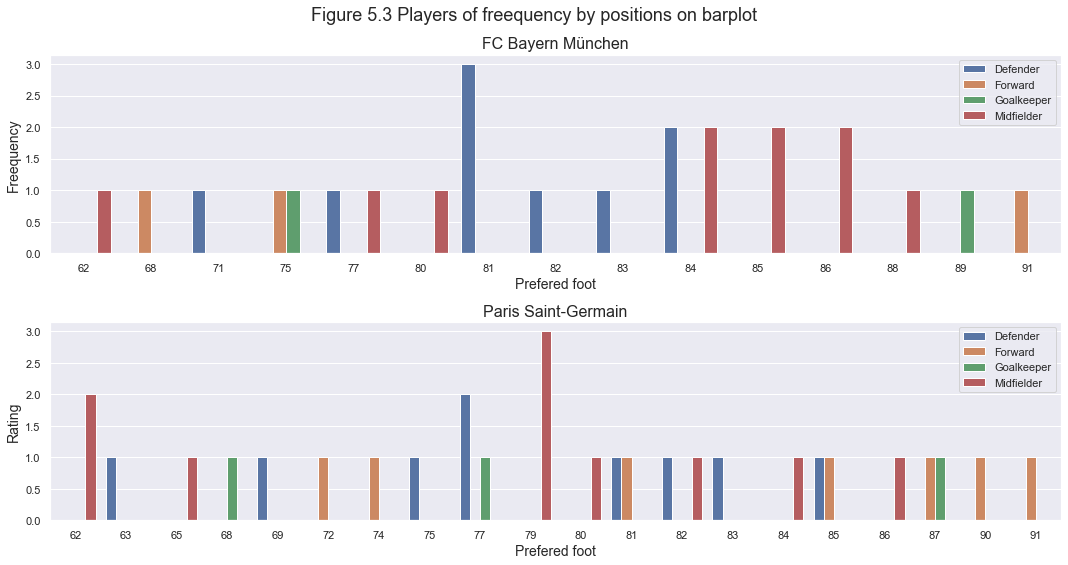

In [64]:
plt.figure(figsize = (15,8))
plt.suptitle('Figure 5.3 Players of freequency by positions on barplot', size = 18)

plt.subplot(2,1,1)
ax1 = sns.barplot(x=bayern_df['rating'], y=bayern_df['full_name'], hue=bayern_df['position'])
ax1.legend(loc = 'upper right')
ax1.set_title("FC Bayern München", size = 16)
ax1.set_ylabel('Freequency', size = 14)
ax1.set_xlabel('Prefered foot', size = 14)
ax1.yaxis.grid(True)

plt.subplot(2,1,2)
ax2 = sns.barplot(x=psg_df['rating'], y=psg_df['full_name'], hue=psg_df['position'])
ax2.legend(loc = 'upper right')
ax2.set_title("Paris Saint-Germain", size = 16)
ax2.set_ylabel('Rating', size = 14)
ax2.set_xlabel('Prefered foot', size = 14)
ax2.yaxis.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])

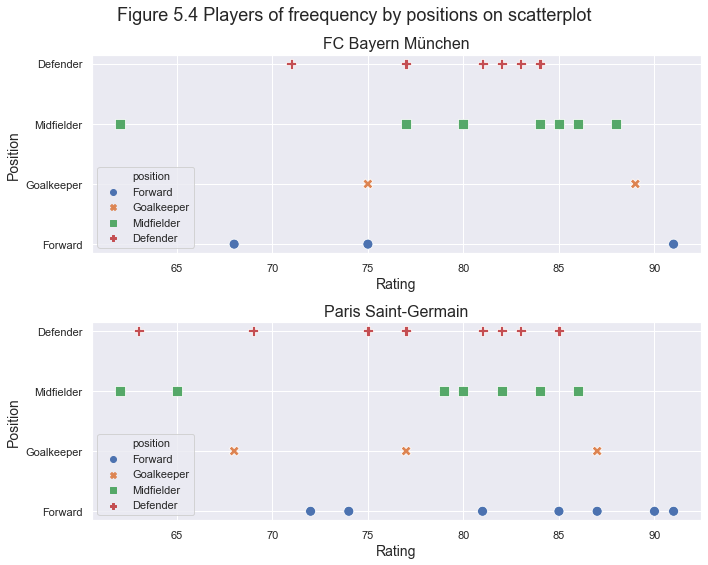

In [65]:
plt.figure(figsize = (10,8))
plt.suptitle('Figure 5.4 Players of freequency by positions on scatterplot', size = 18)

plt.subplot(2,1,1)
ax = sns.scatterplot(data=bayern, x='rating', y='position', hue='position', s=100, style='position')

ax.legend(loc = 'lower left')
ax.set_title("FC Bayern München", size = 16)
ax.set_ylabel('Position', size = 14)
ax.set_xlabel('Rating', size = 14)
ax.yaxis.grid(True)


plt.subplot(2,1,2)
ax1 = sns.scatterplot(data=psg, x='rating', y='position', hue='position', s=100, style='position')

ax1.legend(loc = 'lower left')
ax1.set_title("Paris Saint-Germain", size = 16)
ax1.set_ylabel('Position', size = 14)
ax1.set_xlabel('Rating', size = 14)
ax1.yaxis.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])

Looking at this and graph [5.3](#5.3), we can say that Munich have more players from midfield with a higher rating of 80. this allows Munich to make more changes so that the players do not get tired and that good players play.

### Conclusion  'Analysis of the 2019-2020 Champions League final winner's club'
The success of Bayern's victory in the final was influenced by the number of players with higher levels, that is, good mindfields and defenders. And a goalkeeper with a level greater than 90.

<a id="Conclusion"></a>
#  4. Conclusion

1. England is the leading country in terms of the number of players. And the average age for this country is 24, which is the approximate average for all football players. 
2. The English Premier League is a highly paid and high value League.<br> 
3. The rating of players to some extent depends on the age and experience that the player has gained while still playing in the League. The reputation is affected by such parameters as the League and the stability of the rating.
4. The success of the player does not depend on the leg.
5. The success of Bayern winning the final is the number of players with good players.